In [48]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
from IPython.display import clear_output
import datetime
import seaborn as sns
from tqdm import tqdm
import time
from collections import defaultdict

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import lightgbm as lgb
from catboost import CatBoostRegressor

import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from PIL import Image
import glob
from transformers import BertModel, BertTokenizer
from transformers import pipeline


print('Is CUDA available ?', torch.cuda.is_available())
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Is CUDA available ? True


In [87]:
json_data_training = pd.read_json("train_data.json")
json_data_testing = pd.read_json("test_data.json")
train_label = pd.read_csv("train_label.csv")

In [88]:
json_data_training

,Pid,Uid,Title,Alltags,Category,Concept,Subcategory,Postdate,img_filepath
0,149005,22687@N84,having a drink,life county wild bird water animal closeup fau...,Food,thirsty,Drinks,1426216890,train/22687@N84/149005.jpg
1,149948,17614@N19,"Foto Agne Sterberg, Destination Hga Kusten, AG...",hav mitt hga kusten blsippor nordingr klippor ...,Travel&Active&Sports,mitt,Baseball,1426557920,train/17614@N19/149948.jpg
2,151388,17614@N19,"Foto Agne Sterberg, AGMA Forntid & ventyr AB, ...",is sweden sverige hav soluppgng mitt vr hga ku...,Travel&Active&Sports,mitt,Baseball,1427232557,train/17614@N19/151388.jpg
3,151389,17614@N19,"Foto Agne Sterberg, AGMA Forntid & ventyr AB, ...",is sweden sverige hav soluppgng mitt vr hga ku...,Travel&Active&Sports,mitt,Baseball,1427192316,train/17614@N19/151389.jpg
4,151390,17614@N19,"Foto Agne Sterberg, AGMA Forntid & ventyr AB, ...",is sweden sverige hav soluppgng mitt vr hga ku...,Travel&Active&Sports,mitt,Baseball,1427234146,train/17614@N19/151390.jpg
...,...,...,...,...,...,...,...,...,...
14995,254905,35679@N92,Summer 2015,garden cows pumpkins courtyard pomegranates sa...,Holiday&Celebrations,pumpkins,Halloween,1444977582,train/35679@N92/254905.jpg
14996,382457,44863@N15,www.thravesphoto.co.uk,portrait woman white girl beauty female youth ...,Travel&Active&Sports,diet,"Health,Fitness",1452924796,train/44863@N15/382457.jpg
14997,241322,32899@N73,DSC06507,street bridge people toronto ontario canada ou...,Entertainment,repeat,Music,1443852954,train/32899@N73/241322.jpg
14998,318826,28588@N39,... and to all a goodnight.,christmas wood white mobile night weihnachten ...,Holiday&Celebrations,ornaments,Christmas,1450780890,train/28588@N39/318826.jpg


In [89]:
train_otherfeatures = pd.read_csv("train_features.csv")
ols = sm.OLS(train_label['label'].to_numpy().reshape(-1, 1), train_otherfeatures).fit()
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.915
Model:                            OLS   Adj. R-squared (uncentered):              0.915
Method:                 Least Squares   F-statistic:                          1.352e+04
Date:                Thu, 02 May 2024   Prob (F-statistic):                        0.00
Time:                        00:26:20   Log-Likelihood:                         -31724.
No. Observations:               15000   AIC:                                  6.347e+04
Df Residuals:                   14988   BIC:                                  6.356e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [90]:
train_otherfeatures = pd.read_csv("train_features.csv")
test_otherfeatures = pd.read_csv("test_features.csv")
columns = train_otherfeatures.columns
standardscalar = StandardScaler()
train_otherfeatures = pd.DataFrame(standardscalar.fit_transform(train_otherfeatures))
test_otherfeatures = pd.DataFrame(standardscalar.transform(test_otherfeatures))
train_otherfeatures.columns = columns
test_otherfeatures.columns = columns

#train_image = pd.read_csv("Train_ImageExtract_MonApr29.csv")
#test_image = pd.read_csv("Test_ImageExtract_MonApr29.csv")
#train_image.columns = [f'img{i}' for i in range(train_image.shape[1])]
#test_image.columns = [f'img{i}' for i in range(train_image.shape[1])]

In [91]:
train_features = train_otherfeatures
test_features = test_otherfeatures

train_features

,imgcat_avg,imgcon_avg,imgsubcat_avg,cat_encoded,year_encoded,month_encoded,day_encoded,hour_encoded,numberoftags,tag_weighted_value,uid_frequency,subcat_contribute
0,1.433366,1.019006,0.393643,-0.057223,-1.699630,0.782321,-0.792364,-0.452797,0.475995,0.518685,-0.390902,-0.508140
1,0.199025,0.494398,-0.205109,-0.471887,-1.699630,0.517637,0.634812,-0.865998,-0.479754,-2.617822,2.417267,3.392885
2,0.661093,0.794492,0.173532,-0.492427,0.436084,0.898631,0.012701,-1.931396,-0.300551,-2.499435,2.417267,3.392885
3,0.099777,0.443929,-0.140839,-0.492427,0.373793,0.810523,-0.256915,-0.136369,-0.300551,-2.499435,2.417267,3.392885
4,0.901121,0.921761,0.152291,-0.471887,0.436084,0.517637,0.005235,-2.669508,-0.300551,-2.499435,2.417267,3.392885
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.677210,0.403768,0.631056,-0.606404,-1.699630,-1.013169,1.562910,-1.010788,-0.539488,-1.144944,-0.408903,-0.492770
14996,1.416957,1.108379,-1.265699,-0.467275,-1.586808,-0.137887,1.562910,-0.219226,0.595463,1.924461,-0.426904,-0.435390
14997,0.418246,-1.568394,0.852739,-0.441511,0.436084,-0.956239,-0.123866,-1.010788,-0.061614,0.596645,-0.444905,-0.509348
14998,-0.447348,0.520773,-1.875102,-0.561682,0.373793,-1.660203,-2.049468,0.016463,2.327758,0.555401,-0.426904,-0.495287


array([[<Axes: title={'center': 'imgcat_avg'}>,
        <Axes: title={'center': 'imgcon_avg'}>,
        <Axes: title={'center': 'imgsubcat_avg'}>],
       [<Axes: title={'center': 'cat_encoded'}>,
        <Axes: title={'center': 'year_encoded'}>,
        <Axes: title={'center': 'month_encoded'}>],
       [<Axes: title={'center': 'day_encoded'}>,
        <Axes: title={'center': 'hour_encoded'}>,
        <Axes: title={'center': 'numberoftags'}>],
       [<Axes: title={'center': 'tag_weighted_value'}>,
        <Axes: title={'center': 'uid_frequency'}>,
        <Axes: title={'center': 'subcat_contribute'}>]], dtype=object)

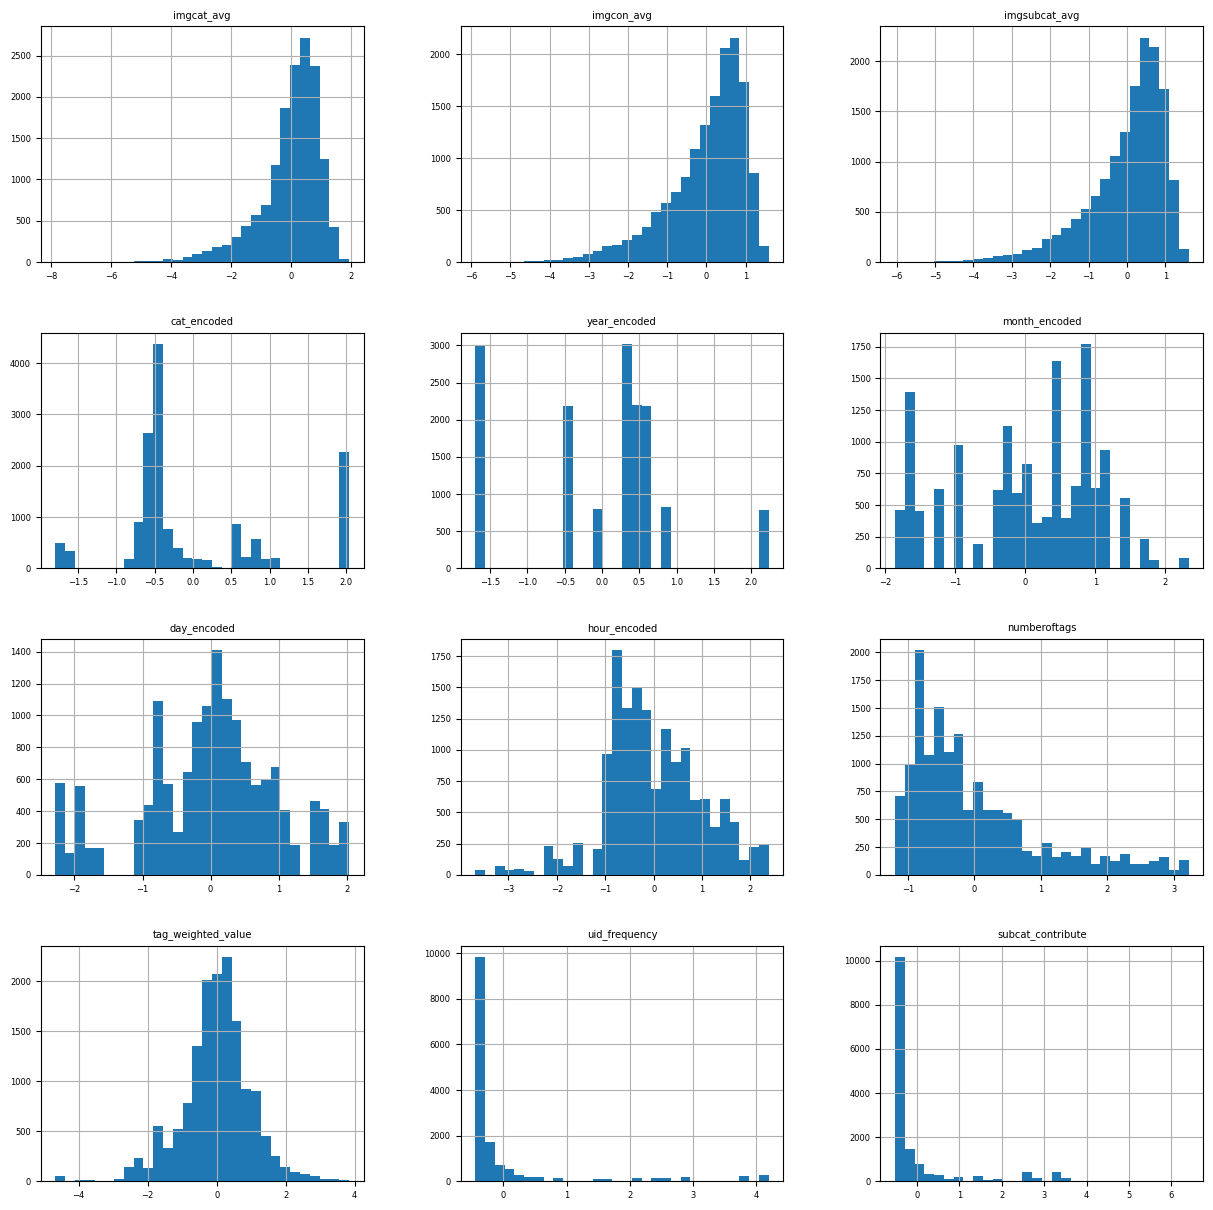

In [94]:
train_features.hist(bins = 30, figsize = (15, 15))

<Axes: >

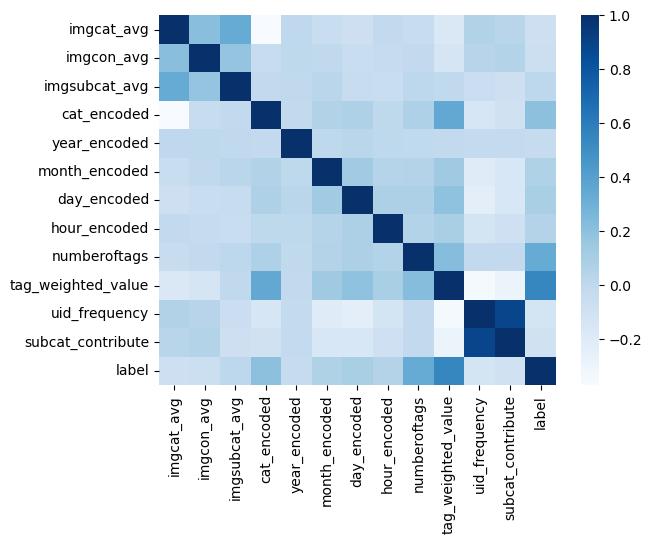

In [7]:
corr = pd.concat([train_features, train_label['label']], axis = 1).corr()
sns.heatmap(corr, cmap="Blues", annot=False)

In [12]:
lightgbm_model = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 1500, verbose = -1)
lightgbm_model.fit(train_features, train_label['label'])

Y_train_hat_gbm = lightgbm_model.predict(train_features)
Y_test_hat_gbm = lightgbm_model.predict(test_features)

test_dict = {'Pid' : json_data_testing['Pid'], 'label': Y_test_hat_gbm}
test_pd = pd.DataFrame(test_dict)

date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_GBM_{date}.csv", index = False)

MAE_gbm = mean_absolute_error(Y_train_hat_gbm, train_label['label'])
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")
train_dict = {"Pid": json_data_training['Pid'], 'label': Y_train_hat_gbm}
train_pd = pd.DataFrame(train_dict)
train_pd.to_csv(f"train_GBM_{date}.csv", index = False)

Light GBM Regression: 1.019


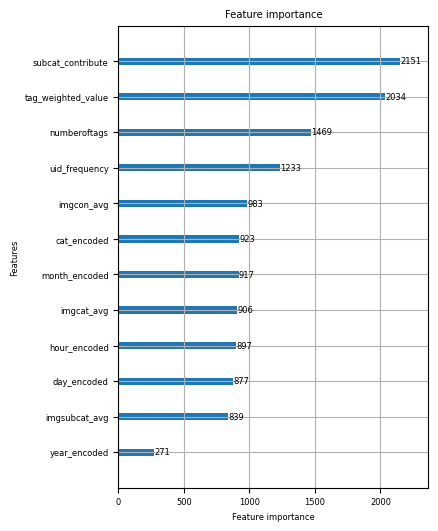

In [13]:
plt.rcParams.update({'font.size': 6})
ax = lgb.plot_importance(lightgbm_model)
fig = ax.figure
fig.set_size_inches(4, 6)

## Optimal Weights

In [61]:
train_image = pd.read_csv("Image_Only_TueApr30_train_epochs1.csv")
test_image = pd.read_csv("Image_Only_TueApr30_test_epochs1.csv")

train_structure = pd.read_csv("train_GBM_TueApr30.csv")
test_structure = pd.read_csv("test_GBM_TueApr30.csv")

In [62]:
date = time.ctime(time.time())[:10].replace(' ', '')
weights = [i/ 100 for i in range(0, 101)]

weights = [i/ 100 - 1 for i in range(0, 201)]
MAE_dict = dict()
min_mae = float('inf')
for w in weights:
    train_price = w* train_image['label'] + (1 - w)* train_structure['label']
    mae = mean_absolute_error(train_label['label'].to_numpy().reshape(-1, 1), train_price.to_numpy().reshape(-1, 1))
    MAE_dict[w] = (mae)
    if mae < min_mae:
        min_mae = mae
        min_weights = w
        
test_pd = pd.DataFrame()
test_pd['Pid'] = test_structure['Pid']
test_pd['label'] = min_weights* test_image['label'] + (1 - min_weights)*test_structure['label']
test_pd.to_csv(f"test_optimalweight_{date}.csv", index = False)
print(f"Minimum MAE weight: {min_weights}")

Minimum MAE weight: -0.06999999999999995


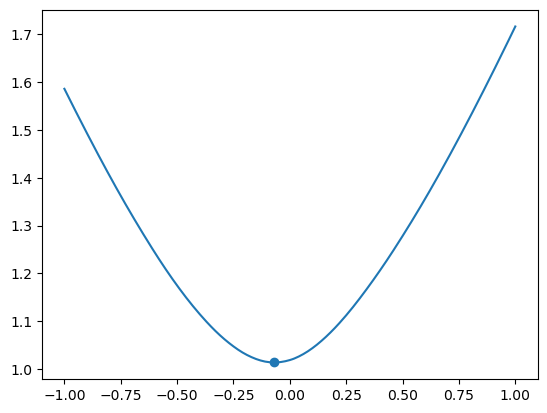

In [24]:
plt.rcParams.update({'font.size': 10})

plt.plot(MAE_dict.keys(), MAE_dict.values())
plt.scatter(min_weights, min_mae)

## Image Info Extraction

In [97]:
train_otherfeatures = pd.read_csv("train_features.csv")
test_otherfeatures = pd.read_csv("test_features.csv")
columns = train_otherfeatures.columns
standardscalar = StandardScaler()
train_otherfeatures = pd.DataFrame(standardscalar.fit_transform(train_otherfeatures))
test_otherfeatures = pd.DataFrame(standardscalar.transform(test_otherfeatures))
train_otherfeatures.columns = columns
test_otherfeatures.columns = columns

train_image = pd.read_csv("Train_ImageExtract_TueApr30.csv")
test_image = pd.read_csv("Test_ImageExtract_TueApr30.csv")
train_image.columns = [f'img{i}' for i in range(train_image.shape[1])]
test_image.columns = [f'img{i}' for i in range(train_image.shape[1])]

train_features = pd.concat([train_otherfeatures, train_image], axis = 1)
test_features = pd.concat([test_otherfeatures, test_image], axis = 1)

In [98]:
train_features

,imgcat_avg,imgcon_avg,imgsubcat_avg,cat_encoded,year_encoded,month_encoded,day_encoded,hour_encoded,numberoftags,tag_weighted_value,uid_frequency,subcat_contribute,img0,img1,img2,img3,img4,img5
0,1.433366,1.019006,0.393643,-0.057223,-1.699630,0.782321,-0.792364,-0.452797,0.475995,0.518685,-0.390902,-0.508140,-0.174081,-1.897268,5.126676,10.796437,10.012718,0.215368
1,0.199025,0.494398,-0.205109,-0.471887,-1.699630,0.517637,0.634812,-0.865998,-0.479754,-2.617822,2.417267,3.392885,-0.118867,-1.303852,3.275175,6.991659,6.488624,0.032515
2,0.661093,0.794492,0.173532,-0.492427,0.436084,0.898631,0.012701,-1.931396,-0.300551,-2.499435,2.417267,3.392885,-0.156443,-1.469738,3.723473,7.936060,7.332458,0.089975
3,0.099777,0.443929,-0.140839,-0.492427,0.373793,0.810523,-0.256915,-0.136369,-0.300551,-2.499435,2.417267,3.392885,-0.135269,-1.282800,3.129756,6.684490,6.273723,0.025680
4,0.901121,0.921761,0.152291,-0.471887,0.436084,0.517637,0.005235,-2.669508,-0.300551,-2.499435,2.417267,3.392885,-0.163521,-1.432016,3.687250,7.711424,7.251096,0.097852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.677210,0.403768,0.631056,-0.606404,-1.699630,-1.013169,1.562910,-1.010788,-0.539488,-1.144944,-0.408903,-0.492770,-0.163957,-1.309515,3.289742,6.989958,6.526994,0.075567
14996,1.416957,1.108379,-1.265699,-0.467275,-1.586808,-0.137887,1.562910,-0.219226,0.595463,1.924461,-0.426904,-0.435390,-0.228920,-2.388163,6.659235,13.795611,12.946809,0.329722
14997,0.418246,-1.568394,0.852739,-0.441511,0.436084,-0.956239,-0.123866,-1.010788,-0.061614,0.596645,-0.444905,-0.509348,-0.127682,-1.504998,3.880596,8.195595,7.695188,0.081204
14998,-0.447348,0.520773,-1.875102,-0.561682,0.373793,-1.660203,-2.049468,0.016463,2.327758,0.555401,-0.426904,-0.495287,-0.198395,-1.615005,4.259735,9.009842,8.393019,0.139494


In [99]:
lightgbm_model = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 1500, verbose = -1)
lightgbm_model.fit(train_features, train_label['label'])

Y_train_hat_gbm = lightgbm_model.predict(train_features)
Y_test_hat_gbm = lightgbm_model.predict(test_features)

test_dict = {'Pid' : json_data_testing['Pid'], 'label': Y_test_hat_gbm}
test_pd = pd.DataFrame(test_dict)

date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_GBM_{date}_ImageExtraction.csv", index = False)

MAE_gbm = mean_absolute_error(Y_train_hat_gbm, train_label['label'])
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")
train_dict = {"Pid": json_data_training['Pid'], 'label': Y_train_hat_gbm}
train_pd = pd.DataFrame(train_dict)
train_pd.to_csv(f"train_GBM_{date}_ImageExtraction.csv", index = False)

Light GBM Regression: 0.98


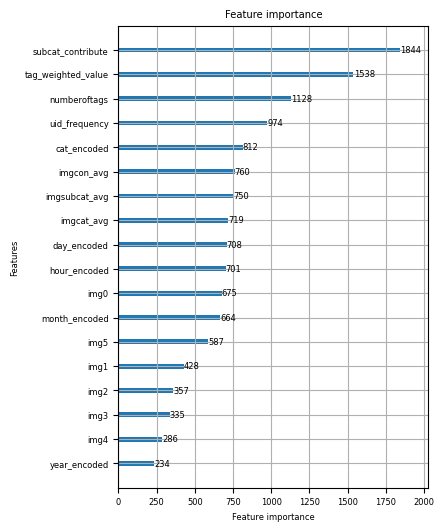

In [100]:
plt.rcParams.update({'font.size': 6})
ax = lgb.plot_importance(lightgbm_model)
fig = ax.figure
fig.set_size_inches(4, 6)

In [101]:
class Vanilla_NN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.linear = nn.Sequential(
            nn.Linear(self.input_size, 32, bias = False),
            nn.LeakyReLU(),
            nn.Linear(32, 64, bias = False),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32, bias = False),
            nn.LeakyReLU(),
            nn.Linear(32, 8, bias = False),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(),
            nn.Linear(8, 1, bias = False)
        )
    def forward(self, x):
        return self.linear(x)
    

In [102]:
def train(model, criterion, optimizer, x, y, epochs = 50):
    x = torch.tensor(x.to_numpy(), dtype = torch.float32)
    y = torch.tensor(y, dtype = torch.float32)

    dataloader = DataLoader(dataset = TensorDataset(x, y), batch_size = 32, shuffle = True)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            y_out = model(x)  
            loss = criterion(y_out, y)
            loss.backward()
            optimizer.step() 
            
    return model

In [103]:
def test(model, x):
    model.eval()
    x = torch.tensor(x.to_numpy(), dtype = torch.float32).to(device)
    pred = model(x).squeeze()
    pred = pred.cpu().detach().numpy()
    return pred

In [104]:
x_train = train_features
y_train = train_label['label'].to_numpy().reshape(-1, 1)
x_test = test_features

linear = LinearRegression()
lasso = Lasso(alpha = 0.5)
svr = SVR(kernel = 'rbf')
cat_model = CatBoostRegressor(n_estimators = 1500, depth = 6, learning_rate = 0.05)
vanilla_nn = Vanilla_NN(x_train.shape[1]).to(device)
optimizer = optim.Adam(vanilla_nn.parameters(), lr = 1*1e-4)
criterion = nn.MSELoss()

linear.fit(x_train, y_train)
lasso.fit(x_train, y_train)
svr.fit(x_train, y_train)
cat_model.fit(x_train, y_train)
clear_output(wait = True)
vanilla_nn = train(vanilla_nn, criterion, optimizer, x_train, y_train)
clear_output(wait = True)


linear_predict = linear.predict(x_train)
lasso_predict = lasso.predict(x_train)
svr_predict = svr.predict(x_train)
cat_predict = cat_model.predict(x_train)
vanilla_nn_predict = test(vanilla_nn, x_train)

print(f"Linear Training MAE: {mean_absolute_error(linear_predict, y_train)}")
print(f"Lasso Training MAE: {mean_absolute_error(lasso_predict, y_train)}")
print(f"SVR Training MAE: {mean_absolute_error(svr_predict, y_train)}")
print(f"Cat Training MAE: {mean_absolute_error(cat_predict, y_train)}")
print(f"NN Training MAE: {mean_absolute_error(vanilla_nn_predict, y_train)}")


linear_predict = linear.predict(x_test)
lasso_predict = lasso.predict(x_test)
svr_predict = svr.predict(x_test)
cat_predict = cat_model.predict(x_test)
vanilla_nn_predict = test(vanilla_nn, x_test)

name = ["linear", "lasso", "svr", "cat", "NN"]
predicts = [linear_predict, lasso_predict, svr_predict, cat_predict, vanilla_nn_predict]
date = time.ctime(time.time())[:10].replace(' ', '')

for i in range(len(name)):
    data = pd.DataFrame()
    data['Pid'] = json_data_testing['Pid']
    data['label'] = predicts[i]
    data.to_csv(name[i] + f"_{date}_old.csv", index = False)

Linear Training MAE: 1.494747651936692
Lasso Training MAE: 1.5758351673919642
SVR Training MAE: 1.422028607370555
Cat Training MAE: 0.9198601143142783
NN Training MAE: 1.351072807689349
